# Problem Set 4, due March 16 at 11:59pm

### Before You Start

This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set to make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions (especially the sections on vectorized computation and computational efficiency).
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using the [Boston Housing Prices Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names).

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf


In [2]:
# Load you data the Boston Housing data into a dataframe
# MEDV.txt containt the median house values and data.txt the other 13 features
# in order ["CRIM", "ZN", "INDUS", "CHAS", "NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT"]
data = np.loadtxt('data.txt')
target = np.loadtxt('MEDV.txt')
bdata_df = pd.DataFrame(data, columns = ['CRIM','ZN','INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
bdata_df['MEDV'] = target

---

## Part 1: Getting oriented


### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Using the same Boston housing prices dataset, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between  median housing price and number of rooms per house. Do this by first (a) regressing the housing price on the number of rooms per house, and then (b) regressing the housing price on the number of rooms per house and the (number of rooms per house) squared.  Interpret your results.

In [3]:
from sklearn import linear_model as lm
# (a) OLS: 'RM' for 'MEDV'
# use reshape(-1,1) for a single feature, reshape(-1,2) for two features

X1 = np.array(bdata_df['RM']).reshape(-1,1)
y = np.array(bdata_df['MEDV'])
reg1 = lm.LinearRegression().fit(X1,y)
print("intercept {} and slopes {} from regression(a)".format(reg1.intercept_, reg1.coef_))

# (b) OLS: 'RM' and 'RM'^2 for 'MEDV'
X2 = np.array(pd.concat([bdata_df['RM'], bdata_df['RM'].pow(2)], axis=1))
reg2 = lm.LinearRegression().fit(X2,y)
print("intercept {} and slopes {} from regression(b)".format(reg2.intercept_, reg2.coef_))


intercept -35.576206874519855 and slopes [8.95992721] from regression(a)
intercept 71.73632810734314 and slopes [-23.78960283   2.46914488] from regression(b)


In [4]:
# alternatively, using statsmodels to get summary table
import statsmodels.api as sm
X1a = sm.add_constant(X1)
model1 = sm.OLS(y, X1a).fit()
print(model1.summary())

X2a = sm.add_constant(X2)
model2 = sm.OLS(y, X2a).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     452.3
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           4.12e-72
Time:                        18:23:18   Log-Likelihood:                -1678.2
No. Observations:                 506   AIC:                             3360.
Df Residuals:                     504   BIC:                             3369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.5762      2.748    -12.944      0.0

In the first regression, on average 1 additional room per house is associated with 8960 USD increase in median value of owner-occupied homes.

In the second regression, the polynomial regression is non-linear. The change of median value of homes is depending on the number or rooms per house. The slope is not constant. For example, when room number increases from 6 to 7, the median housing value is estimated to increase by 8308 USD; when room number increases from 8 to 9, the median housing value is estimated to increase by 18184 USD.

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but often this will result in overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 25-fold cross-validation to fit regression (a) above, i.e. the linear fit of housing price on number of rooms per house. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Plot the distribution of the 25 slope coefficients using a histogram, then draw a vertical line at the value of the slope coefficient that you estimated in 1.1 using the full dataset.  What do you notice?

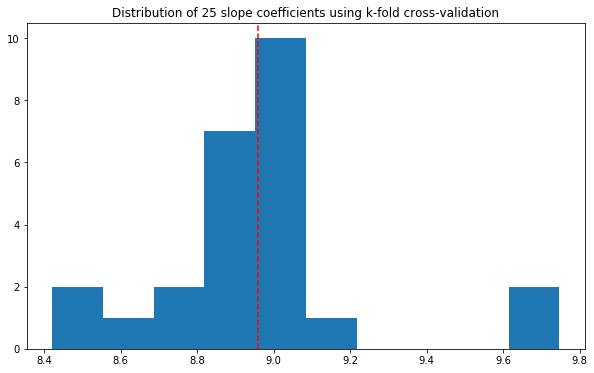

In [5]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=25)

coef_arr = np.array([])
for train_index, test_index in kf.split(X1):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = lm.LinearRegression().fit(X_train, y_train)
    coef_arr = np.append(coef_arr, reg.coef_)

plt.figure(figsize=(10,6))
plt.hist(coef_arr)
plt.axvline(reg1.coef_, color='r', linestyle='--')
plt.title('Distribution of 25 slope coefficients using k-fold cross-validation')
plt.show()

The slope coefficient from 1.1 is at about center of the distribution, and the variation of 25 folds is high, ranging from about 8.5 to 9.7.

### 1.3 Regression lines

Create a scatterplot of housing price on rooms per house, and add the two regression lines from 1.1 (or 1.2 if you prefer to do so). Show the linear regression line in red, and the linear+quadratic regression line (which may have curvature) in blue.  Label these two regression lines with the corresponding regression equations (i.e. the slope and intercept of the line).

Bonus: Add the 95% confidence bands (i.e.,  the area that has a 95% chance of containing the true regression line) to each of these lines.

Note: You can get 2 points even without the confidence bands (if the other lines are correct, the axes are labeled, the lines are labeled, the points are plotted correctly, and so forth). If you do everything perfectly including the confidence bands, you get 2 points. If you do something else wrong and would normally receive less than two points, the confidence intervals can replace lost points up to 0.5.

Useful reference: [1](https://www.medcalc.org/manual/scatter_diagram_regression_line.php), [2](https://rpubs.com/aaronsc32/regression-confidence-prediction-intervals)

You can directly use some packages to calculate the bands.

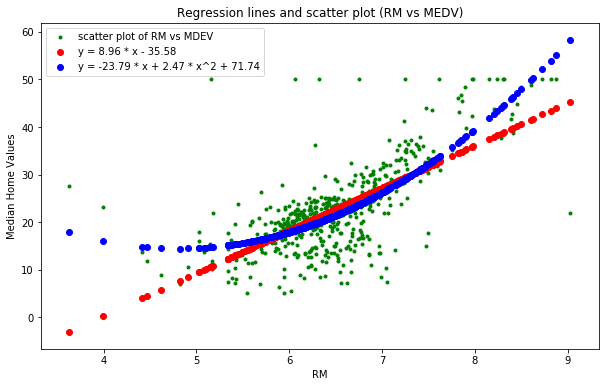

In [6]:
plt.figure(figsize=(10,6))

# scatter plot of RM and MDEV
plt.scatter(X1, y, c='g', 
            marker='.', label='scatter plot of RM vs MDEV')
# linear regression line from 1.1 (a)
plt.scatter(X1, np.dot(X1, reg1.coef_) + reg1.intercept_, 
         c='r', label='y = 8.96 * x - 35.58')
# non-linear regression line from 1.1 (b)
plt.scatter(X1, np.dot(X2, reg2.coef_) + reg2.intercept_, 
         c='b', label='y = -23.79 * x + 2.47 * x^2 + 71.74')

plt.title('Regression lines and scatter plot (RM vs MEDV)')
plt.xlabel('RM')
plt.ylabel('Median Home Values')
plt.legend(loc='upper left')

plt.show()


## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (average rooms per house)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the housing price on the number of rooms per house. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds
* How do your coefficients compare to the ones estimated through standard libraries? Does this depend on *R*?

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: Some people like to include a MaxIterations parameter in their gradient descent algorithm, to prevent divergence. *

In [7]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    co-efficient
"""
def bivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    # initialize the parameters
    alpha_old = np.random.rand()
    beta_old = np.random.rand()
    alpha = np.random.rand()
    beta = np.random.rand()
    n = len(xvalues)
    
    # tolerence and iteration counter
    epsilon = 1e-4
    cnt = 0
    cost = 0
    while (np.abs(alpha_old - alpha) > epsilon or np.abs(beta_old - beta) > epsilon):
        alpha_old = alpha
        beta_old = beta
        alpha = alpha_old - R / n * ((alpha_old + beta_old * xvalues - yvalues).sum())
        beta = beta_old - R / n * (((alpha_old + beta_old * xvalues - yvalues) * xvalues).sum())
        # print the cost to check it is decreasing
        cost = 1.0 / (2*n) * (((yvalues - alpha - beta * xvalues) ** 2).sum())
#         print(cost)
        
        cnt += 1
        if cnt > MaxIterations:
            print('Iterations exceeded maximum number. Stopping...')
            break

    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta, cnt, cost

In [8]:
# function call
print('Learning Rate=0.045\n', bivariate_ols(np.array(bdata_df['RM']), y, 0.045, 100000), '\n')

Time taken: 0.29 seconds
Learning Rate=0.045
 (-35.381775132200936, 8.930289855150649, 10165, 22.246158244315833) 



In [9]:
print('Learning Rate=0.04\n', bivariate_ols(np.array(bdata_df['RM']), y, 0.04, 100000), '\n')

Time taken: 0.32 seconds
Learning Rate=0.04
 (-35.35748727276446, 8.926587640921143, 11213, 22.246216878773375) 



In [10]:
print('Learning Rate=0.03\n', bivariate_ols(np.array(bdata_df['RM']), y, 0.03, 100000), '\n')

Time taken: 0.40 seconds
Learning Rate=0.03
 (-35.284544601339725, 8.915468942017558, 14102, 22.24643441490863) 



When R = 0.045, we get alpha = 8.93, beta = -35.38 that minimizes the loss function.
It takes 10201 iterations to converge. The total runtime is 0.30 second.

When R = 0.04, we get alpha = 8.93, beta = -35.36 that minimizes the loss function. It takes 11296 iterations to converge. The total runtime is 0.33 second.

When R = 0.03, we get alpha = 8.92, beta = -35.28 that minimizes the loss function.
It takes 14062 iterations to converge. The total runtime is 0.40 second.

All of the three learning rates get us very close estimations to what we got in 1.1 (alpha=8.96, beta=-35.58). Sufficiently small R can converge faster, and these R are good enough to estimate alpha and beta for the accuracy I specified.

### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [11]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using CRIM and RM as independent variables. Standardize these variables before before inputting them to the gradient descent algorithm. 

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with 2-3 different values of R.

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [12]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""

def multivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    # Initialize variablse
    N, m = np.shape(xvalues)
    alpha_old = np.random.rand()
    beta_old = np.random.rand(m)
    alpha = np.random.rand()
    beta = np.random.rand(m)
    
    # tolerance and iteration counter
    cost_list = np.empty(1)
    epsilon = 1e-4
    cnt = 0
    while(np.abs(alpha_old-alpha) > epsilon or np.max(np.abs(beta_old-beta)) > epsilon):
        alpha_old = alpha
        beta_old = beta
        alpha = alpha_old - R / N * ((alpha_old +  np.dot(xvalues, beta_old) - yvalues).sum())
        beta = beta_old - R / N * np.dot(xvalues.T, (alpha_old +  np.dot(xvalues, beta_old) - yvalues))
        
        # print the cost to check it is descreasing
        cost = 1.0 / (2* N) * np.linalg.norm(yvalues - alpha - np.dot(xvalues, beta))**2
        cost_list= np.append(cost_list, cost)
#         print(cost_list)
        
        # If it takes too many iterations terminate
        cnt += 1
        if cnt > MaxIterations:
            print('Iterations exceeded maximum number. Stopping...')
            break
        
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))    
    return alpha, beta, cnt

In [13]:
# function call
print('Learning Rate=0.05\n', multivariate_ols(standardize(np.array(bdata_df[['CRIM','RM']])), y, 0.05, 100000), '\n')

Time taken: 0.01 seconds
Learning Rate=0.05
 (22.530956538655232, array([-2.24361178,  5.8169275 ]), 183) 



In [14]:
print('Learning Rate=0.04\n', multivariate_ols(standardize(np.array(bdata_df[['CRIM','RM']])), y, 0.04, 100000), '\n')

Time taken: 0.01 seconds
Learning Rate=0.04
 (22.530462284606713, array([-2.24360706,  5.81690701]), 224) 



In [15]:
print('Learning Rate=0.02\n', multivariate_ols(standardize(np.array(bdata_df[['CRIM','RM']])), y, 0.02, 100000), '\n')

Time taken: 0.03 seconds
Learning Rate=0.02
 (22.527993572980545, array([-2.2443569 ,  5.81601407]), 418) 



When R = 0.05, we get alpha = 22.53, beta = (-2.24, 5.82) that minimizes the loss function.
It takes 183 iterations to converge. The total runtime is 0.01 second.

When R = 0.04, we get alpha = 22.53, beta = (-2.24, 5.82) that minimizes the loss function. It takes 224 iterations to converge. The total runtime is 0.02 second.

When R = 0.02, we get alpha = 22.53, beta = (-2.24, 5.82) that minimizes the loss function.
It takes 418 iterations to converge. The total runtime is 0.03 second.

Sufficiently small learning rates can provide good enough estimations of coefficient and intercept. Just that larger ones tend to be faster and have less iterations and less runtime.

Interpretation: holding other factors constant, 1 more room per house indicates an increase of 5820 USD in median housing value on average; holding others constant, 1 more percentage crime rate per capita indicates a decrease of 2244 USD in median housing value on average.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm?

In [16]:
# Standardized
print('Learning Rate=0.1\n', multivariate_ols(standardize(np.array(bdata_df[['CRIM','RM']])), y, 0.1, 100000), '\n')
print('Learning Rate=0.01\n', multivariate_ols(standardize(np.array(bdata_df[['CRIM','RM']])), y, 0.01, 100000), '\n')
print('Learning Rate=0.001\n', multivariate_ols(standardize(np.array(bdata_df[['CRIM','RM']])), y, 0.001, 100000), '\n')

Time taken: 0.01 seconds
Learning Rate=0.1
 (22.531927490939758, array([-2.24344151,  5.8171437 ]), 96) 

Time taken: 0.03 seconds
Learning Rate=0.01
 (22.522950009832563, array([-2.24576922,  5.81424156]), 766) 

Time taken: 0.23 seconds
Learning Rate=0.001
 (22.432969090545296, array([-2.25124496,  5.7985267 ]), 5412) 



In [17]:
# Non-standardized
print('Learning Rate=0.1\n', multivariate_ols(np.array(bdata_df[['CRIM','RM']]), y, 0.1, 100000), '\n')
print('Learning Rate=0.01\n', multivariate_ols(np.array(bdata_df[['CRIM','RM']]), y, 0.01, 100000), '\n')
print('Learning Rate=0.001\n', multivariate_ols(np.array(bdata_df[['CRIM','RM']]), y, 0.001, 100000), '\n')

Time taken: 0.03 seconds
Learning Rate=0.1
 (nan, array([nan, nan]), 325) 



/Users/qyinhelena/anaconda3/envs/APIs_geospatial/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in subtract


Time taken: 1.48 seconds
Learning Rate=0.01
 (-29.035658364758554, array([-0.26419927,  8.10758375]), 32902) 

Iterations exceeded maximum number. Stopping...
Time taken: 5.45 seconds
Learning Rate=0.001
 (-19.210713339990537, array([-0.29670662,  6.62776151]), 100001) 



When non-standardized, the loss function becomes more "spherical" and it takes so much longer runtime to converge, even for the same R. When R=0.1 and X-array non-standardized, it diverges. When R=0.001 and X-array is non-standardized, it exceeds the maximum iteration limit, but still not reaching the local minima. When R=0.01, it converges but it takes so much longer time and more iterations. Thus, standardization is necessary to efficiently and accurately find local minima in GD.

### **2.5 Implement  Mini-Batch Gradient Descent (MB-GD)**
MB-GD is a Gradient Descent variant that in large data sets can converge faster and is computationally less intensive. Implement MB-GD for question 2.3. Tune the learning rate, number of iterations and "mini-batch" size
so that you compute the estimates within a 1e-2 tolerance. Do not use a batch-size greater than 32.
In summary you go over the entire data set for n epochs. At the beginning of each epoch you shuffle your data once and then you pick k batches (approximately k=#of data points/batch_size). For each batch you compute the gradient, update the parameters and move to the next batch.
MB-GD is similar to Stochastic Gradient Descent but instead of using one sample to compute the gradient we use a batch of samples at each iteration. You can find details about MB-GD here:
https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [18]:
# def mb_gd(xvalues, yvalues, R=0.01, batch_size=32, MaxIter=10000):
#     start_time = time.time()
#     # Initialize variablse
#     N, m = np.shape(xvalues)
#     alpha_old = np.random.rand()
#     beta_old = np.random.rand(m)
#     alpha = np.random.rand()
#     beta = np.random.rand(m)
#     cost_old = np.inf
#     cost_new = np.linalg.norm(yvalues)
#     xvalues_init = xvalues
#     yvalues_init = yvalues
    
#     # tolerance, iteration counter and n epoches
#     cost_list = np.empty(1)
#     epsilon = 1e-6
#     cnt = 0
#     n_epoch = int(N/batch_size)
    
#     for epoch in range(n_epoch+1): # random shuffle for each epoch
#         ind = np.random.choice(N, batch_size, replace=False)
#         xvalues = xvalues_init[ind, :]
#         yvalues = yvalues_init[ind]
#         N, _ = xvalues.shape

#         # update alpha beta for each batch
#         for data in range(batch_size):
#             cnt += 1
#             if (np.abs(alpha_old-alpha) > epsilon or np.max(np.abs(beta_old-beta)) > epsilon):
#                 alpha_old = alpha
#                 beta_old = beta

#                 alpha = alpha_old - R / N * ((alpha_old +  np.dot(xvalues, beta_old) - yvalues).sum())
#                 beta = beta_old - R / N * np.dot(xvalues.T, (alpha_old +  np.dot(xvalues, beta_old) - yvalues))

#                 cost = 1.0 / (2* N) * np.linalg.norm(yvalues - alpha - np.dot(xvalues, beta))**2
#                 cost_list= np.append(cost_list, cost)
# #                 print(cost_list)
                
#              #elif cnt > MaxIter:
# #                 print('Iterations exceeded maximum number. Stopping...')
# #                 break
                
#             else:
#                 print("Time taken: {:.2f} seconds".format(time.time() - start_time))   
#                 return alpha, beta, cnt

#     print("Time taken: {:.2f} seconds".format(time.time() - start_time))    
#     return alpha, beta, cnt

In [19]:
"""
Function
--------
mb_gd
    Gradient Decent with mini batches. Used to find co-efficients of regression that is convex

Parameters
----------
xvalue, yvalues : narray
    xvalue: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
BatchSize: Int
    number of datapoints in a batch
    
Returns
-------
alpha: float
    intercept
    
beta: array[float]
    co-efficient
    
cnt: int
    count of iterations
"""
from sklearn.utils import shuffle

def mb_gd(xvalues, yvalues, R=0.01, MaxIterations=1000, BatchSize=32):
    start_time = time.time()
    # Initiate variables
    N, m = np.shape(xvalues)
    alpha = np.random.rand()
    beta = np.random.rand(m)
    
    # in this implementation I keep track of the objective function to determine convergence
    cost_old = np.inf
    cost_new = np.linalg.norm(yvalues)
    epsilon = 1e-4
    cnt = 0

    for i in range(MaxIterations):
        cost_old = cost_new
        # shuffle data
        Xb, yb = shuffle(xvalues, yvalues)
        
        # for each of the floor(n/K) batches do gradient steps
        for offset in range(0, N, BatchSize):
            
            end = offset + BatchSize
            batchx, batchy = Xb[offset:end], yb[offset:end]
            
            # update alpha and beta for each batch
            alpha = alpha - R / N * ((alpha + np.dot(batchx, beta) - batchy).sum())
            beta = beta - R / N * np.dot(batchx.T, (alpha +  np.dot(batchx, beta) - batchy))
            # compute new cost
            cost_new = 1.0 / (2 * N) * np.linalg.norm(batchy - alpha - np.dot(batchx, beta))**2
            
        if((np.abs(cost_old-cost_new) < epsilon) or (cnt > MaxIterations)):
            print("Time taken: {:.2f} seconds".format(time.time() - start_time))    
            return alpha, beta, cnt
            
        cnt += 1
        
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))    
    return alpha, beta, cnt

In [20]:
# OLS: regressing 'MEDV' on standardized ’CRIM‘ and 'RM'
# use reshape(-1,1) for a single feature, reshape(-1,2) for two features

X3 = standardize(np.array(bdata_df[['CRIM','RM']]))
y = np.array(bdata_df['MEDV'])
reg3 = lm.LinearRegression().fit(X3,y)
print("intercept {} and slopes {} from regression(a)".format(reg3.intercept_, reg3.coef_))

intercept 22.53280632411067 and slopes [-2.24281888  5.8177965 ] from regression(a)


In [21]:
print('Learning Rate=0.01 and 32 batches\n', mb_gd(standardize(np.array(bdata_df[['CRIM','RM']])), y, 
                                                   0.01, 1000, 32), '\n')

Time taken: 0.48 seconds
Learning Rate=0.01 and 32 batches
 (22.53190997411802, array([-2.24306554,  5.81724333]), 1000) 



In [22]:
print('Learning Rate=0.1 and 32 batches\n', mb_gd(standardize(np.array(bdata_df[['CRIM','RM']])), y, 
                                                    0.1, 1000, 32), '\n')

Time taken: 0.47 seconds
Learning Rate=0.1 and 32 batches
 (22.532249025191813, array([-2.2440273 ,  5.81877786]), 1000) 



In [23]:
print('Learning Rate=0.02 and 32 batches\n', mb_gd(standardize(np.array(bdata_df[['CRIM','RM']])), y, 
                                                    0.02, 1000, 32), '\n')

Time taken: 0.46 seconds
Learning Rate=0.02 and 32 batches
 (22.533035925177334, array([-2.24222604,  5.81790327]), 1000) 



I don't observe speedup as a total. Although it iterate many times, the speed iterating for each batch is extremely fast.

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Make sure to first standardize your features before proceeding.

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that in one of two ways. If you're feeling confident, use k-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be three, corresponding to the intercept and the two coefficients for CRIM and RM). Or if you want to do the quick and dirty version, randomly divide your data into a training set (66%) and testing set (34%) and use the training set to re-fit the regression from 2.3 above. 

*NOTE: * If using k-fold cross-validation, you will end up with a different set of parameters for each fold. In this case, use the parameters from the fold that has the highest test performance.

In [24]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction
"""
# compute RMSE
def compute_rmse(predictions, yvalues):
    pre = np.asarray(predictions)
    y = np.asarray(yvalues)
    rmse = np.sqrt(np.sum((pre-y) ** 2) / float(len(y)))
    return rmse

In [25]:
# slicing data by column name
X_cr_rm = standardize(np.array(bdata_df[['CRIM','RM']]))

# 25-fold cross validation on training data
kf = KFold(n_splits=25)

# iterate through 25 folds
for train_index, test_index in kf.split(X_cr_rm):
    X_train_cr_rm, X_test_cr_rm = X_cr_rm[train_index], X_cr_rm[test_index]
    y_train_cr_rm, y_test_cr_rm = y[train_index], y[test_index]
    
    # fit the mini-batch gd model
    inter4, coef4, iter4 = mb_gd(X_train_cr_rm, y_train_cr_rm, 0.02, 1000, 32)
    
    # predict y for current fold
    pred_y = np.dot(X_train_cr_rm, coef4) + inter4
    
    # print intercept, coefficient and RMSE for each fold
    print(inter4, coef4, compute_rmse(pred_y, y_train_cr_rm))

Time taken: 0.46 seconds
22.52532771721301 [-2.24384916  5.79313478] 6.382219873433155
Time taken: 0.42 seconds
22.682225781358785 [-2.30025563  5.7451674 ] 6.342751270730907
Time taken: 0.54 seconds
22.528203238057095 [-2.24440273  5.79881166] 6.412008882154863
Time taken: 0.30 seconds
22.54269945678394 [-2.24452616  5.82631673] 6.424991116401622
Time taken: 0.26 seconds
22.550467829471557 [-2.25308862  5.80135356] 6.4129561775759365
Time taken: 0.46 seconds
22.59815873047791 [-2.26847225  5.81655083] 6.413371567032139
Time taken: 0.45 seconds
22.698834006317224 [-2.30601617  5.77197478] 6.351780235456768
Time taken: 0.45 seconds
22.406434539383756 [-2.24518348  5.66287471] 6.274492021143502
Time taken: 0.45 seconds
22.35141338847525 [-2.18903918  5.74895141] 6.303104910517313
Time taken: 0.45 seconds
22.30077936132886 [-2.22863017  5.44557826] 6.267903211674273
Time taken: 0.41 seconds
22.425884190842286 [-2.20522477  5.8054697 ] 6.384079508460449
Time taken: 0.38 seconds
22.49800850

When RMSE = 5.34, we have the highest performance from this fold. The intercept is 22.193, and CRIM and RM coefficients are -2.381, 6.334.

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the RMSE on your test cases, i.e. take the model parameters that you found above, predict the values for just the test instances, and compare the actual to the predicted values. If you did this the k-fold way above, this will be the average RMSE across the k test sets. If you did this the quick and dirty way above, this will just be the RMSE on your single test set.

What is your test RMSE?  How does it compare to the performance of your nearest neighbor algorithm from the last problem set?

In [26]:
# 25-fold cross validation on testing data
kf = KFold(n_splits=25)
test_rmse = np.array([])
for train_index, test_index in kf.split(X_cr_rm):
    X_train_cr_rm, X_test_cr_rm = X_cr_rm[train_index], X_cr_rm[test_index]
    y_train_cr_rm, y_test_cr_rm = y[train_index], y[test_index]
    
    # plug in parameters of lowest RMSE from 3.1 to predict y test
    pred_y_t = np.dot(X_test_cr_rm, np.array([-2.381, 6.334])) + 22.193
    test_rmse = np.append(test_rmse, compute_rmse(pred_y_t, y_test_cr_rm))

print('Average RMSE for testing set: ', np.mean(test_rmse))


Average RMSE for testing set:  5.414911982915681


The average RMSE on test dataset is 5.41. The MB-GD algorithm performs better than NN algorithm in PS3, which was 7.37.

### Extra Credit 1: Logistic Regression

For extra credit, implement logistic regression using gradient descent. Create a new variable (EXPENSIVE) to indicate whether the median housing price is more than $40,000. Use your model  a logistic regression of EXPENSIVE on CHAS and RM. Report your results.

In [27]:
# create new binary column using lambda functions (dataframes)
bdata_df['EXPENSIVE'] = bdata_df.apply(lambda x: 1 if x['MEDV'] > 40 else 0, axis = 1)

In [28]:
def multivariate_log_reg(xvalues, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    # Initialize variablse
    N, m = np.shape(xvalues)
    alpha_old = np.random.rand()
    beta_old = np.random.rand(m)
    alpha = np.random.rand()
    beta = np.random.rand(m)
    
    # tolerance and iteration counter
    cost_list = np.empty(1)
    epsilon = 1e-4
    cnt = 0
    while(np.abs(alpha_old-alpha) > epsilon or np.max(np.abs(beta_old-beta)) > epsilon):
        alpha_old = alpha
        beta_old = beta
        vec_1 = 1.0 /(1 + np.exp(-(alpha_old + np.dot(xvalues, beta_old)))) - yvalues
        alpha = alpha_old - R / N * (vec_1.sum())
        beta = beta_old - R / N * (np.dot(np.transpose(xvalues), vec_1))
        
        # print the cost to check it is descreasing （NEED TO CHANGE BELOW!!!）
#         cost = 1.0 / (2* N) * np.linalg.norm(yvalues - alpha - np.dot(xvalues, beta))**2
#         cost_list= np.append(cost_list, cost)
#         print(cost_list)
        
        # If it takes too many iterations terminate
        cnt += 1
        if cnt > MaxIterations:
            print('Iterations exceeded maximum number. Stopping...')
            break
        
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))    
    return alpha, beta, cnt

In [29]:
print('Learning Rate=0.1\n', multivariate_log_reg(np.array(bdata_df[['CHAS','RM']]),
                                                   np.array(bdata_df['EXPENSIVE']),
                                                   0.1, 100000))

Time taken: 1.20 seconds
Learning Rate=0.1
 (-20.237799081999768, array([1.18285756, 2.48705379]), 50577)


In [30]:
print('Learning Rate=0.2\n', multivariate_log_reg(np.array(bdata_df[['CHAS','RM']]),
                                                   np.array(bdata_df['EXPENSIVE']),
                                                   0.2, 100000))

Time taken: 0.90 seconds
Learning Rate=0.2
 (-21.920810672507358, array([1.2167098 , 2.71362919]), 37119)


The cofficients converge as shown above. If CHAS is 1, the probability is 90.25% for the median housing value to be EXPENSIVE.

## 4 Regularization 

### 4.1 Get prepped

Step 1: Create new interaction variables between each possible pair of the F_s features. If you originally had *K* features, you should now have K+(K*(K+1))/2 features. Standardize all of your features.

Step 2: For simplicity, generate a single training and testing set.  Randomly sample 66% of your data and call this the training set, and set aside the remaining 34% as your test set.

In [41]:
# reload datasets to dataframe
data = np.loadtxt('data.txt')
target = np.loadtxt('MEDV.txt')
bdata_df_new = pd.DataFrame(data, columns = ['CRIM','ZN','INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])

# add new interaction variables between each possible pair
k = 13
for i in range(0, k):
    for j in range(i, k):
        bdata_df_new[str(bdata_df_new.columns[i] + '*' + bdata_df_new.columns[j])] = bdata_df_new.iloc[:,i]*bdata_df_new.iloc[:,j]

bdata_df_new['MEDV'] = target # add target at the last column

# check column number is correct, there is one more column for target and others are features
print(bdata_df_new.shape, k+(k*(k+1))/2)
# check and store column names
column_names = list(bdata_df_new.columns)
# print(column_names)

(506, 105) 104.0


In [42]:
from sklearn.model_selection import train_test_split

# split the new dataframe with interaction terms into training and testing set by 66% and 34%
bdata_X_train, bdata_X_test, bdata_y_train, bdata_y_test = train_test_split(np.array(bdata_df_new.iloc[:,0:105]), 
                                                                            np.array(bdata_df_new.iloc[:,-1]),
                                                                            test_size=0.34, 
                                                                            random_state=13579, 
                                                                            shuffle=True)

### 4.2 Overfitting (sort of)
Now, using your version of multivariate regression from 2.3, let's overfit the training data. Using your training set, regress housing price on as many of those K+(K*(K+1))/2 features as you can (Don't forget to add quadratic terms. Form instance, RM^2.).  If you get too greedy, it's possible this will take a long time to compute, so start with 5-10 features, and if you have the time, add more features.

Report the RMSE when you apply your model to your training set and to your testing set. How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [43]:
# First trial: get indeces for respective column names (8 features, not too ambitious)
features1 = ['CRIM','RM','CRIM*RM','RM*RM','DIS','NOX','NOX*NOX','DIS*NOX']
index1 = []
for i in range(len(column_names)):
    if column_names[i] in features1:
        index1.append(i)
# print(index1)

# standardize selected features on training set
Xtrain6 = standardize(bdata_X_train[:, index1])
ytrain6 = bdata_y_train

# train on multivariate ols model
inter6, coef6, iter6 = multivariate_ols(Xtrain6, ytrain6, 0.04, 100000)

# compute rmse to check performance
pred_y_6 = np.dot(Xtrain6, coef6) + inter6
train6_rmse = compute_rmse(pred_y_6, ytrain6)
print('Training RMSE:', train6_rmse)
# print('\nIntercept: ', inter6, '\nCoefficients: ', coef6)

# standardize selected features on testing set
Xtest6 = standardize(bdata_X_test[:, index1])
ytest6 = bdata_y_test

# compute rmse to check performance on testing set with the above
pred_y_6test = np.dot(Xtest6, coef6) + inter6
test6_rmse = compute_rmse(pred_y_6test, ytest6)
print('Testing RMSE:', test6_rmse)

Time taken: 1.06 seconds
Training RMSE: 5.9629667055898095
Testing RMSE: 4.67316824763923


The RMSEs are both small for training set and testing set. Compared with other models (3.2 and NN), this model has smaller RMSE for training  testing. Testing RMSE is even smaller than Training, so it does a pretty good job.

In [46]:
# Second trial: now let's randomly select more features (80 features, quite ambitious!)
index2 = np.random.choice(len(column_names)-1, 80, replace=False)
# print(index2)

# standardize selected features on training set
Xtrain7 = standardize(bdata_X_train[:, index2])
ytrain7 = bdata_y_train

# train on multivariate ols model
inter7, coef7, iter7 = multivariate_ols(Xtrain7, ytrain7, 0.04, 10000000)

# compute rmse to check performance
pred_y_7 = np.dot(Xtrain7, coef7) + inter7
train7_rmse = compute_rmse(pred_y_7, ytrain7)
print('Training RMSE:', train7_rmse)
# print('\nIntercept: ', inter7, '\nCoefficients: ', coef7)

# standardize selected features on testing set
Xtest7 = standardize(bdata_X_test[:, index2])
ytest7 = bdata_y_test

# compute rmse to check performance on testing set with the above
pred_y_7test = np.dot(Xtest7, coef7) + inter7
test7_rmse = compute_rmse(pred_y_7test, ytest7)
print('Testing RMSE:', test7_rmse)

Time taken: 11.40 seconds
Training RMSE: 2.8898698268043805
Testing RMSE: 4.096842973294588


As I ambitiously and randomly throw much more features in the model, the training RMSE is getting much smaller and the testing RMSE gets slightly smaller but not as much. This is sort of overfitting in my understanding.

### 4.3 Ridge regularization
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model from 4.2 above on your training data. Try this for several different values of lambda, and report your RMSE for each lambda separately for your training and testing data. How do these numbers compare to each other, to the RMSE from 4.2,  to the RMSE from 2.3, and to the RMSE from nearest neighbors?

Go brag to your friends about how you just implemented ridge-regularized multivariate regression using gradient descent optimization, from scratch. If you still have friends.

In [47]:
def multivariate_ols_ridge(xvalues, yvalues, R=0.01, MaxIterations=1000, lamb=100):
#     start_time = time.time()
    # Initialize variablse
    N, m = np.shape(xvalues)
    alpha_old = np.random.rand()
    beta_old = np.random.rand(m)
    alpha = np.random.rand()
    beta = np.random.rand(m)
    
    # tolerance and iteration counter
    cost_list = np.empty(1)
    epsilon = 1e-4
    cnt = 0
    while(np.abs(alpha_old-alpha) > epsilon or np.max(np.abs(beta_old-beta)) > epsilon):
        alpha_old = alpha
        beta_old = beta
        alpha = alpha_old - R / N * ((alpha_old +  np.dot(xvalues, beta_old) - yvalues).sum())
        beta = beta_old - R / N * (np.dot(xvalues.T, (alpha_old +  np.dot(xvalues, beta_old) - yvalues)) 
                                   + lamb * beta_old) # ridge L2 penalization
        
        # print the cost to check it is descreasing
        cost = 1.0 / (2* N) * np.linalg.norm(yvalues - alpha - np.dot(xvalues, beta))**2
        cost_list= np.append(cost_list, cost)
#         print(cost_list)
        
        # If it takes too many iterations terminate
        cnt += 1
        if cnt > MaxIterations:
            print('Iterations exceeded maximum number. Stopping...')
            break
        
#     print("Time taken: {:.2f} seconds".format(time.time() - start_time))    
    return alpha, beta, cnt

In [48]:
## Refit the second trial in 4.2, where I have 80 features
# train on multivariate ols model with ridge regularization, lambda=50
inter8, coef8, iter8 = multivariate_ols_ridge(Xtrain7, ytrain7, 0.04, 10000000, 50)

# compute rmse to check performance
pred_y_8 = np.dot(Xtrain7, coef8) + inter8
train8_rmse = compute_rmse(pred_y_8, ytrain7)
print('Training RMSE:', train8_rmse, '\nIterations: ', iter8)

# compute rmse to check performance on testing set with the above
pred_y_8test = np.dot(Xtest7, coef8) + inter8
test8_rmse = compute_rmse(pred_y_8test, ytest7)
print('Testing RMSE:', test8_rmse)

Training RMSE: 4.319830962839745 
Iterations:  615
Testing RMSE: 4.454881961285991


In [49]:
## same as above, but lambda = 100 (increase penalty)
inter8, coef8, iter8 = multivariate_ols_ridge(Xtrain7, ytrain7, 0.04, 10000000, 100)

# compute rmse to check performance
pred_y_8 = np.dot(Xtrain7, coef8) + inter8
train8_rmse = compute_rmse(pred_y_8, ytrain7)
print('Training RMSE:', train8_rmse, '\nIterations: ', iter8)

# compute rmse to check performance on testing set with the above
pred_y_8test = np.dot(Xtest7, coef8) + inter8
test8_rmse = compute_rmse(pred_y_8test, ytest7)
print('Testing RMSE:', test8_rmse)

Training RMSE: 4.5712318545026385 
Iterations:  369
Testing RMSE: 4.591003878320222


The RMSEs after regularization remain at a small level, way smaller than those of 2.3 and NN. Training RMSE is about the same as testing RMSE when lambda = 50 and lambda = 100. When lambda increases, iteratoins decrease. There is definitely space to tune the parameters.

Compared to 4.2, RMSE for training is getting larger and RMSE for testing is getting smaller. It means regularization is useful. Run time is way shorter too.

### Extra Credit 2: Cross-validate lambda

Use k-fold cross-validation to select the optimal value of lambda. Report the average RMSE across all training sets, and the average RMSE across all testing sets. How do these numbers compare to each other, to the RMSE from your previous efforts?  Finally, create a scatter plot that shows RMSE as a function of lambda.

In [53]:
# slice 80 features from whole dataset, standardize X array
X_cv = standardize(np.array(bdata_df_new.iloc[:, index2]))
y_cv = np.array(bdata_df_new.iloc[:, -1])

# 25-fold cross validation for lambda
kf = KFold(n_splits=25)

train_rmse_lst = []
test_rmse_lst = []
for lamb in range(100, 1001, 100): # lambda from 100 to 1000, 100 at a step
    
    train_rmse_cv = []
    test_rmse_cv = []
    for train_index, test_index in kf.split(X_cv):
        X_train, X_test = X_cv[train_index], X_cv[test_index]
        y_train, y_test = y_cv[train_index], y_cv[test_index]
        inter, coef, iteration = multivariate_ols_ridge(X_train, y_train, 0.04, 1000000, lamb)
#         print(inter, coef, iteration)

        pred_y_train = np.dot(X_train, coef) + inter
        rmse_tr = compute_rmse(pred_y_train, y_train)
        
        pred_y_test = np.dot(X_test, coef) + inter
        rmse_te = compute_rmse(pred_y_test, y_test)
        
        train_rmse_cv.append(rmse_tr)
        test_rmse_cv.append(rmse_te)
    
    train_rmse_lst.append(np.mean(train_rmse_cv))
    test_rmse_lst.append(np.mean(test_rmse_cv))

# print(train_rmse_lst, test_rmse_lst)

In [54]:
print('Average training RMSE for each lambda: ', train_rmse_lst, '\nAverage testing RMSE for each lambda: ', test_rmse_lst)

Average training RMSE for each lambda:  [4.329845002609694, 4.552379527662397, 4.68409578725884, 4.785125420540549, 4.870857759405928, 4.947201108428253, 5.01703619649792, 5.081957315290999, 5.142934258326165, 5.200604637731724] 
Average testing RMSE for each lambda:  [4.656478128101492, 4.754913911757529, 4.817795333739116, 4.870934816486276, 4.919900281665656, 4.966200502705851, 5.01051901890798, 5.053154806262375, 5.0943147500978005, 5.13412647424658]


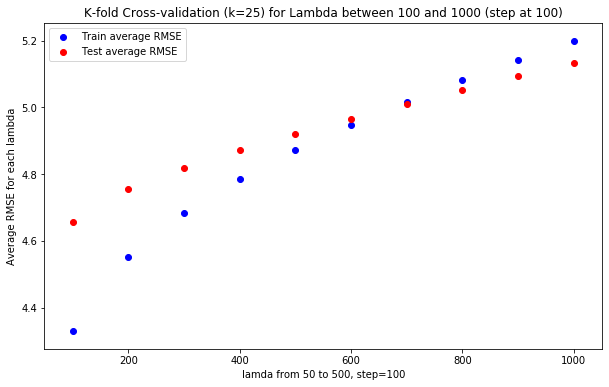

In [57]:
plt.figure(figsize=(10,6))
plt.scatter(range(100,1001,100), train_rmse_lst, c='b', label='Train average RMSE')
plt.scatter(range(100,1001,100), test_rmse_lst, c='r', label='Test average RMSE')
plt.legend(loc='upper left')
plt.xlabel('lamda from 50 to 500, step=100')
plt.ylabel('Average RMSE for each lambda')
plt.title('K-fold Cross-validation (k=25) for Lambda between 100 and 1000 (step at 100)')
plt.show()

When lambda is somewhere above 700, the average Test RMSE will be lower than the average Train RMSE, meaning the overfitting can be regulated more effectively. However, since we have 80 features in the model, the RMSE is lifted up when we increase the penalties. The RMSEs are higher than RMSEs in 4.3 (train rmse=2.88, test rmse=4.09).

###  Extra Credit 3: AdaGrad

AdaGrad is a method to implement gradient descent with different learning rates for each feature. Adaptive algorithms like this one are being extensively used especially in neural network training. Implement AdaGrad on 2.3 but now use CRIM, RM and DIS as independent variables. Standardize these variables before inputting them to the gradient descent algorithm. Tune the algorithm until you estimate the regression coefficients within a tolerance of 1e-1. Use mini-batch gradient descent in this implementation. In summary for each parameter (in our case one intercept and three slopes) the update step of the gradient (in this example $\beta_j$) at iteration $k$ of the GD algorithm becomes:

$$\beta_j=\beta_j -\frac{R}{\sqrt{G^{(k)}_j}}\frac{\partial J(\alpha,\beta_1,\ldots)}{\partial \beta_j}$$ where
$G^{(k)}_j=\sum_{i=1}^{k} (\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j})^2$ and $R$ is your learning rate. The notation $\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j}$ corresponds to the value of the gradient at iteration $(i)$. Essentially we are "storing" information about previous iteration gradients. Doing that we effectively decrease the learning rate slower when a feature $x_i$ is sparse (i.e. has many zero values which would lead to zero gradients). Although this method is not necessary for our regression problem, it is good to be familiar with these methods as they are widely used in neural network training.  

*Discuss your results here*